In [6]:
import sys
sys.path.append('..')
from utilities import readDiffTAD, formatCell
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import interpolation

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
def setStatus(x):
    if x == 'Normal':
        return 0
    elif x == 'Loss':
        return -1
    elif x == 'Deletion':
        return -2
    elif x == 'Gain':
        return 1
    elif x == 'Amplification':
        return 2
    else:
        raise ValueError

In [4]:
cell = 'GM12878'

In [7]:
names = {'chrom': str, 'start': int, 'end': int, 'cnv': 'str'}
df = pd.read_csv(
    f'{cell}-CNV-UCSC.bed', names=names.keys(), dtype=names, 
    usecols=[0,1,2,3], skiprows=2, sep='\t')
df['status'] = df['cnv'].apply(setStatus)

In [10]:
diffTADs = readDiffTAD('GM12878', diffOnly=True, X=False)

In [12]:
diffTADs

,chrom,start,end,type,direction
12,chr1,85410000,85530000,ASTAD,1
29,chr1,14150000,14290000,ASTAD,1
30,chr1,25710000,25850000,ASTAD,1
59,chr1,31870000,32030000,ASTAD,1
60,chr1,34910000,35070000,ASTAD,1
...,...,...,...,...,...
8478,chr9,133930000,135870000,ASTAD,1
8485,chr9,136370000,138710000,ASTAD,1
8489,chr9,133290000,135870000,ASTAD,1
8493,chr9,135870000,138710000,ASTAD,1


In [13]:
width = 1
domainSize = 10
size = domainSize * ((width * 2) + 1)
allDiffTAD = []

for i, chrom, start, end, name, direction in diffTADs.itertuples():
    sub = df.loc[df['chrom'] == chrom]
    idxs = list(sub[sub['start'].between(start, end)].index)
    
    # Get number of indexes with domain
    idxRange = idxs[-1] - idxs[0]
    minIdx = idxs[0] - (idxRange * width)
    maxIdx = idxs[-1] + (idxRange * width)
    
    # Get domain +/- 1 domain length
    domain = sub[sub.index.isin(list(range(minIdx, maxIdx)))]
    zoom = size / len(domain['status'])
    allDiffTAD.append(interpolation.zoom(domain['status'], zoom))
allDiffTAD = np.array(allDiffTAD).astype(int)

In [14]:
boundary = [None] * (width * domainSize - 1)
internal = ['|'] + ([None] * (domainSize - 2)) + ['|']
xTicks = [str(-width)] + boundary + internal + boundary + [str(-width)]
yTicks = [None for x in range(len(diffTADs))]

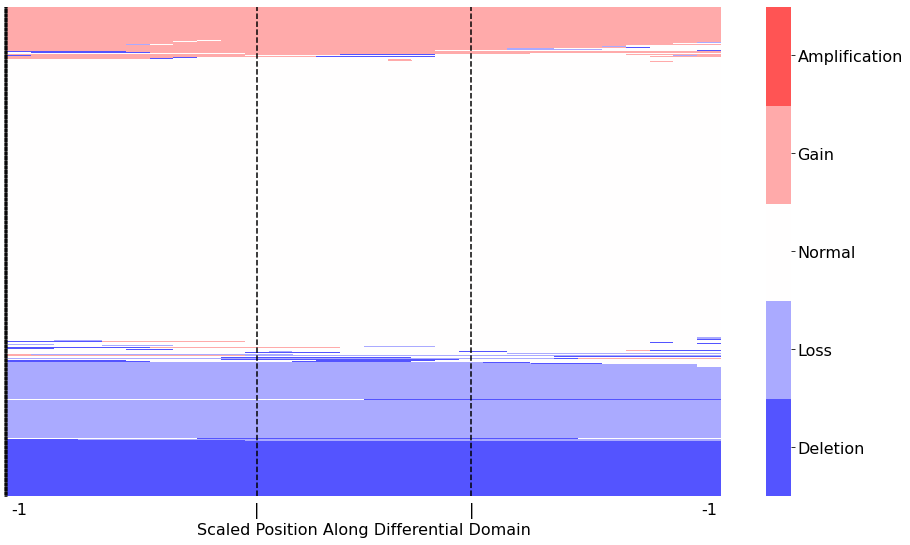

In [15]:
# Sort array for visualisation purpose
sortedIdx = np.argsort(allDiffTAD.mean(axis=1))[::-1]

fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(
    allDiffTAD[sortedIdx], xticklabels=xTicks, yticklabels=yTicks, 
    cmap=sns.color_palette('bwr', 5), vmin=-2, vmax=2, center=0, ax=ax)
ax.tick_params(left=True, bottom=False)
ax.axvline(10.5, color='black', ls='--')
ax.axvline(19.5, color='black', ls='--')
ax.set_xlabel('Scaled Position Along Differential Domain')

vmap = {-2: 'Deletion', -1: 'Loss', 0: 'Normal', 1: 'Gain', 2: 'Amplification'}
n = len(vmap)

# Get the colorbar object from the Seaborn heatmap
colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
fig.savefig(f'{cell}-CNVstatus.svg')